<a href="https://colab.research.google.com/github/shabayadletzh/Final-Project/blob/main/Final_Project_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
!pip -q install lxml tqdm pytrends

### Importing libraries for the project

In [104]:
# Standard library
import random

# Data
import numpy as np
import pandas as pd

# Plotting (final plots)
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Set reproducibility, device, and modeling hyperparameters (12-month horizon).

In [105]:
# Reproducibility: ensures training is stable across reruns
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device selection (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Forecast design
LOOKBACK = 24     # how many past months are used as lags
HORIZON = 12      # predict the next 12 months

# Time split windows measured in forecast start months
VAL_MONTHS = 6
TEST_MONTHS = 6

Using device: cpu


### Load the processed dataset produced by EDA and validate required columns exist. (Please run Final_Project_EDA first so this notebook will be able to run using scraped data from that notebook)

In [106]:
# Load the EDA-produced panel; this avoids re-scraping in the modeling notebook
full_df = pd.read_csv("data/processed/monthly_panel_with_exog.csv", parse_dates=["month"])
full_df = full_df.sort_values(["app_id", "month"]).reset_index(drop=True)

print("Loaded rows:", len(full_df), "| Games:", full_df["app_id"].nunique())
display(full_df.head())

# Required columns (if missing, EDA notebook didn't run or dataset export is wrong)
required_cols = [
    "app_id","game","month","avg_players",
    "update_posts","trend_score",
    "upd_3m","upd_6m","tr_3m","tr_6m",
    "sin_m","cos_m",
    "ev_winter_holidays","ev_lunar_new_year","ev_valentines","ev_spring_break",
    "ev_summer","ev_back_to_school","ev_halloween","ev_black_friday"
]
missing = [c for c in required_cols if c not in full_df.columns]
if missing:
    raise ValueError(f"Missing required columns in processed dataset: {missing}")

Loaded rows: 1775 | Games: 20


,month,app_id,game,avg_players,update_posts,trend_score,sin_m,cos_m,ev_winter_holidays,ev_lunar_new_year,ev_valentines,ev_spring_break,ev_summer,ev_back_to_school,ev_halloween,ev_black_friday,upd_3m,upd_6m,tr_3m,tr_6m
0,2018-01-01,440,Team Fortress 2,53432.10,0.0,0.0,0.500000,8.660254e-01,1,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,2018-02-01,440,Team Fortress 2,37715.11,0.0,0.0,0.866025,5.000000e-01,0,1,1,0,0,0,0,0,0.0,0.0,0.0,0.0
2,2018-03-01,440,Team Fortress 2,36781.88,0.0,0.0,1.000000,6.123234e-17,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0
3,2018-04-01,440,Team Fortress 2,39180.46,0.0,0.0,0.866025,-5.000000e-01,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0
4,2018-05-01,440,Team Fortress 2,38847.02,0.0,0.0,0.500000,-8.660254e-01,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0


### Create supervised windows: features include lagged players + exogenous summaries + future calendar features; target is next 12 months.

In [107]:
def make_windows_with_exog(df: pd.DataFrame, lookback: int, horizon: int) -> pd.DataFrame:
    """
    Convert each game’s monthly time series into supervised samples.

    Feature vector x is built as:
    - player lags: last lookback months of log1p(avg_players)
    - exogenous summaries at forecast start (already shifted in EDA): upd_3m/upd_6m/tr_3m/tr_6m
    - future calendar features for each forecast month (safe because deterministic from date)

    Target y:
    - next horizon months of log1p(avg_players)
    """
    samples = []

    cal_cols = [
        "sin_m", "cos_m",
        "ev_winter_holidays",
        "ev_lunar_new_year",
        "ev_valentines",
        "ev_spring_break",
        "ev_summer",
        "ev_back_to_school",
        "ev_halloween",
        "ev_black_friday"
    ]
    exog_now_cols = ["upd_3m", "upd_6m", "tr_3m", "tr_6m"]

    for app_id, g in df.groupby("app_id"):
        g = g.sort_values("month").reset_index(drop=True)

        # Target series in log space for stability
        y_series = np.log1p(g["avg_players"].values.astype(float))

        # Only create samples that have enough history and future
        for t in range(lookback, len(g) - horizon + 1):
            # Lag feature block (captures momentum/seasonality in the series itself)
            x_lags = y_series[t - lookback : t]

            # Exogenous summaries known at forecast time (already shifted by 1 month in EDA)
            x_exog_now = g.loc[t, exog_now_cols].values.astype(float)

            # Future calendar features for each horizon month; flattened into one vector
            x_future_cal = g.loc[t : t + horizon - 1, cal_cols].values.astype(float).reshape(-1)

            x = np.concatenate([x_lags, x_exog_now, x_future_cal], axis=0)
            y = y_series[t : t + horizon]

            samples.append({
                "app_id": app_id,
                "game": g.loc[t, "game"],
                "start_month": g.loc[t, "month"],
                "x": x,
                "y": y
            })

    return pd.DataFrame(samples)

samples_df = make_windows_with_exog(full_df, LOOKBACK, HORIZON)
print("Total supervised samples:", len(samples_df))
display(samples_df.head(3))

Total supervised samples: 1075


,app_id,game,start_month,x,y
0,440,Team Fortress 2,2020-01-01,"[10.886185683107772, 10.537842603115411, 10.51...","[10.99539206093056, 11.003932327841213, 11.126..."
1,440,Team Fortress 2,2020-02-01,"[10.537842603115411, 10.512787798518534, 10.57...","[11.003932327841213, 11.126967793534956, 11.11..."
2,440,Team Fortress 2,2020-03-01,"[10.512787798518534, 10.575958954714407, 10.56...","[11.126967793534956, 11.11525172516852, 11.103..."


### Time-based split that works for multi-step horizons: split on available forecast start months (prevents empty test set).

In [108]:
# With horizon forecasting, the last possible start month is earlier than the raw last month.
# We define split boundaries based on the start_months that actually exist in samples_df.
max_start_month = samples_df["start_month"].max()

# Define test and validation boundaries in "start_month" space
test_start = (max_start_month - pd.DateOffset(months=TEST_MONTHS - 1)).to_period("M").to_timestamp(how="start")
val_start  = (test_start - pd.DateOffset(months=VAL_MONTHS)).to_period("M").to_timestamp(how="start")

def split_label(m):
    if m >= test_start:
        return "test"
    if m >= val_start:
        return "val"
    return "train"

samples_df["split"] = samples_df["start_month"].apply(split_label)

print("val_start:", val_start, "| test_start:", test_start, "| max_start_month:", max_start_month)
display(samples_df["split"].value_counts())

train_df = samples_df[samples_df["split"] == "train"].reset_index(drop=True)
val_df   = samples_df[samples_df["split"] == "val"].reset_index(drop=True)
test_df  = samples_df[samples_df["split"] == "test"].reset_index(drop=True)

val_start: 2024-01-01 00:00:00 | test_start: 2024-07-01 00:00:00 | max_start_month: 2024-12-01 00:00:00


,count
split,
train,835
val,120
test,120


### Baseline forecasting + core metrics (MAE/RMSE/sMAPE). Reference point before Torch.

In [109]:
def smape(y_true, y_pred, eps=1e-8):
    # Symmetric MAPE: stable scale-free percentage-like error
    denom = np.maximum(np.abs(y_true) + np.abs(y_pred), eps)
    return float(np.mean(2.0 * np.abs(y_pred - y_true) / denom))

def eval_forecasts(y_true_log, y_pred_log):
    # Evaluate on original player scale for interpretability
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {"MAE": float(mae), "RMSE": float(rmse), "sMAPE": smape(y_true, y_pred)}

def predict_baselines(df: pd.DataFrame, lookback: int, horizon: int):
    # Baselines operate only on the lag block, which is the first LOOKBACK values in x
    X = np.stack(df["x"].values)
    Y = np.stack(df["y"].values)
    lags = X[:, :lookback]

    # Naive: repeat last value
    naive = np.repeat(lags[:, -1][:, None], horizon, axis=1)

    # Seasonal naive: reuse values from the same months one year earlier (requires lookback >= 12)
    if lookback >= 12:
        seasonal = np.zeros_like(naive)
        for k in range(horizon):
            seasonal[:, k] = lags[:, (lookback - 12) + k]
    else:
        seasonal = np.full_like(naive, np.nan)

    # MA3: average last 3 months
    ma3 = np.repeat(np.mean(lags[:, -3:], axis=1)[:, None], horizon, axis=1)

    return Y, {"naive": naive, "seasonal_naive": seasonal, "ma3": ma3}

# Evaluate baselines on val and test splits
for split_name, df_split in [("val", val_df), ("test", test_df)]:
    if len(df_split) == 0:
        print(f"\nBaselines on {split_name.upper()}: (no samples)")
        continue

    Y_true, preds = predict_baselines(df_split, LOOKBACK, HORIZON)
    print(f"\nBaselines on {split_name.upper()}:")
    for name, Y_hat in preds.items():
        if np.isnan(Y_hat).any():
            continue
        m = eval_forecasts(Y_true, Y_hat)
        print(f"{name:15s} MAE={m['MAE']:.1f} RMSE={m['RMSE']:.1f} sMAPE={m['sMAPE']:.3f}")


Baselines on VAL:
naive           MAE=22507.5 RMSE=36738.0 sMAPE=0.268
seasonal_naive  MAE=28698.6 RMSE=52037.3 sMAPE=0.321
ma3             MAE=22484.8 RMSE=38324.4 sMAPE=0.257

Baselines on TEST:
naive           MAE=18447.9 RMSE=34661.2 sMAPE=0.228
seasonal_naive  MAE=26355.4 RMSE=45685.8 sMAPE=0.305
ma3             MAE=18712.1 RMSE=33032.1 sMAPE=0.238


### Add a precision table: percent of forecasts within 10/20/30% error bands (baseline-only here; model precision comes after training).

In [110]:
def mape(y_true, y_pred, eps=1e-8):
    # Mean absolute percentage error on original scale
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), eps)))

def precision_row(y_true_log, y_pred_log, split_name, model_name, bands=(0.10, 0.20, 0.30), eps=1e-8):
    # Convert from log1p space back to raw scale and flatten all horizons into one vector
    y_true = np.expm1(y_true_log).reshape(-1)
    y_pred = np.expm1(y_pred_log).reshape(-1)

    rel_err = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), eps)

    row = {
        "split": split_name.upper(),
        "model": model_name,
        "MAPE": mape(y_true, y_pred, eps=eps),
        "median_rel_err": float(np.median(rel_err)),
    }
    for b in bands:
        row[f"within_{int(b*100)}%"] = float(np.mean(rel_err <= b))
    return row

precision_rows = []
for split_name, df_split in [("val", val_df), ("test", test_df)]:
    if len(df_split) == 0:
        continue
    Y_true, preds = predict_baselines(df_split, LOOKBACK, HORIZON)
    for name, Y_hat in preds.items():
        if np.isnan(Y_hat).any():
            continue
        precision_rows.append(precision_row(Y_true, Y_hat, split_name, name))

precision_baselines_df = pd.DataFrame(precision_rows).sort_values(["split", "median_rel_err"]).reset_index(drop=True)
display(precision_baselines_df)

,split,model,MAPE,median_rel_err,within_10%,within_20%,within_30%
0,TEST,ma3,0.332519,0.143670,0.381250,0.618750,0.740278
1,TEST,naive,0.323731,0.145601,0.377778,0.614583,0.761111
2,TEST,seasonal_naive,0.509671,0.183036,0.327083,0.538194,0.670139
3,VAL,ma3,0.353278,0.158121,0.338194,0.584028,0.709028
4,VAL,naive,0.391241,0.158175,0.332639,0.594444,0.702083
5,VAL,seasonal_naive,0.456626,0.176936,0.312500,0.533333,0.634028


### Prepare Torch datasets: stack arrays and standardize features using train-only statistics.

In [111]:
class WindowDataset(Dataset):
    """
    Dataset wrapper for (X, y) used by DataLoader.
    """
    def __init__(self, X, Y):
        # Store as float32 tensors for Torch
        self.x = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]

# Convert dataframe columns of arrays into stacked matrices
X_train = np.stack(train_df["x"].values); Y_train = np.stack(train_df["y"].values)
X_val   = np.stack(val_df["x"].values);   Y_val   = np.stack(val_df["y"].values)
X_test  = np.stack(test_df["x"].values);  Y_test  = np.stack(test_df["y"].values)

# Standardize X using train statistics only (prevents information leakage)
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0) + 1e-8
X_train_z = (X_train - mu) / sigma
X_val_z   = (X_val   - mu) / sigma
X_test_z  = (X_test  - mu) / sigma

# Standardize y (in log space) using train only
y_mu = Y_train.mean()
y_sigma = Y_train.std() + 1e-8
Y_train_z = (Y_train - y_mu) / y_sigma
Y_val_z   = (Y_val   - y_mu) / y_sigma
Y_test_z  = (Y_test  - y_mu) / y_sigma

# DataLoaders control batching and shuffling
train_loader = DataLoader(WindowDataset(X_train_z, Y_train_z), batch_size=64, shuffle=True)
val_loader   = DataLoader(WindowDataset(X_val_z, Y_val_z), batch_size=256, shuffle=False)
test_loader  = DataLoader(WindowDataset(X_test_z, Y_test_z), batch_size=256, shuffle=False)

input_dim = X_train_z.shape[1]
print("Input dim:", input_dim, "| Horizon:", HORIZON)

Input dim: 148 | Horizon: 12


### Define a simple Torch MLP forecaster: input is the engineered feature vector; output is a 12-step forecast.

In [112]:
class MLPForecaster(nn.Module):
    """
    Simple feed-forward model:
    - Learns nonlinear mapping from lags + factors to multi-step forecast.
    - Output dimension equals the forecast horizon.
    """
    def __init__(self, input_dim, output_dim, hidden1=128, hidden2=64, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, output_dim),
        )

    def forward(self, x):
        return self.net(x)

# Instantiate model and training components
model = MLPForecaster(input_dim=input_dim, output_dim=HORIZON).to(device)
criterion = nn.MSELoss()                      # regression loss in standardized log space
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # stable default optimizer

print(model)

MLPForecaster(
  (net): Sequential(
    (0): Linear(in_features=148, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=12, bias=True)
  )
)


### Train the Torch model with early stopping (keep best validation weights).

In [113]:
def run_epoch(model, loader, train: bool):
    """
    One pass over a dataloader.
    - train=True: gradients + parameter updates
    - train=False: evaluation only
    """
    model.train() if train else model.eval()
    total, n = 0.0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            pred = model(xb)
            loss = criterion(pred, yb)

            if train:
                loss.backward()
                optimizer.step()

        total += loss.item() * xb.size(0)
        n += xb.size(0)

    return total / max(n, 1)

EPOCHS = 80
PATIENCE = 10

best_val = float("inf")
best_state = None
pat = 0

for epoch in range(1, EPOCHS + 1):
    tr = run_epoch(model, train_loader, True)
    va = run_epoch(model, val_loader, False)

    # Print periodically to monitor learning dynamics
    if epoch == 1 or epoch % 5 == 0:
        print(f"Epoch {epoch:03d} trainMSE={tr:.5f} valMSE={va:.5f}")

    # Track best validation model for generalization
    if va < best_val - 1e-6:
        best_val = va
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        pat = 0
    else:
        pat += 1
        if pat >= PATIENCE:
            print("Early stopping. Best val:", best_val)
            break

# Restore best weights
if best_state is not None:
    model.load_state_dict(best_state)

Epoch 001 trainMSE=0.92239 valMSE=0.78810
Epoch 005 trainMSE=0.20798 valMSE=0.22063
Epoch 010 trainMSE=0.17846 valMSE=0.20553
Epoch 015 trainMSE=0.15960 valMSE=0.16665
Epoch 020 trainMSE=0.15631 valMSE=0.15825
Epoch 025 trainMSE=0.14479 valMSE=0.15260
Epoch 030 trainMSE=0.14093 valMSE=0.16618
Epoch 035 trainMSE=0.13037 valMSE=0.14535
Epoch 040 trainMSE=0.12806 valMSE=0.15435
Early stopping. Best val: 0.14250193536281586


### Evaluate Torch model on test data and compute the same metrics as baselines.

In [114]:
def predict_torch(model, loader):
    """
    Collect predictions and true values in standardized y space.
    """
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for xb, yb in loader:
            yhat = model(xb.to(device)).cpu().numpy()
            preds.append(yhat)
            trues.append(yb.numpy())

    return np.vstack(trues), np.vstack(preds)

# Predict standardized targets
Yz_true, Yz_pred = predict_torch(model, test_loader)

# Undo standardization to return to log scale
Y_true_log = (Yz_true * y_sigma) + y_mu
Y_pred_log = (Yz_pred * y_sigma) + y_mu

print("Torch TEST metrics:", eval_forecasts(Y_true_log, Y_pred_log))

Torch TEST metrics: {'MAE': 19496.49678881196, 'RMSE': 30802.181033719502, 'sMAPE': 0.26648573235156625}


### Create a precision table for the Torch model (same 10/20/30% bands) to compare with baseline precision.

In [115]:
def precision_table_for_model(Y_true_log, Y_pred_log, split_name="TEST"):
    """
    Precision summary for a trained model:
    - MAPE
    - median relative error
    - % within 10/20/30% relative error
    """
    y_true = np.expm1(Y_true_log).reshape(-1)
    y_pred = np.expm1(Y_pred_log).reshape(-1)
    rel_err = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), 1e-8)

    return pd.DataFrame([{
        "split": split_name,
        "model": "torch_mlp",
        "MAPE": mape(y_true, y_pred),
        "median_rel_err": float(np.median(rel_err)),
        "within_10%": float(np.mean(rel_err <= 0.10)),
        "within_20%": float(np.mean(rel_err <= 0.20)),
        "within_30%": float(np.mean(rel_err <= 0.30)),
    }])

torch_precision_df = precision_table_for_model(Y_true_log, Y_pred_log, split_name="TEST")
display(torch_precision_df)

,split,model,MAPE,median_rel_err,within_10%,within_20%,within_30%
0,TEST,torch_mlp,0.384583,0.170176,0.340278,0.55625,0.6625


### Final plot: show only forecast vs actual for the last possible window of a few games used as an example.

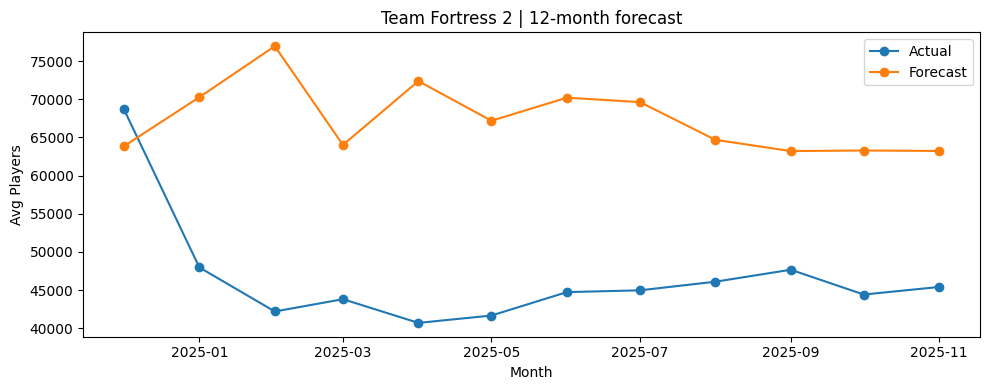

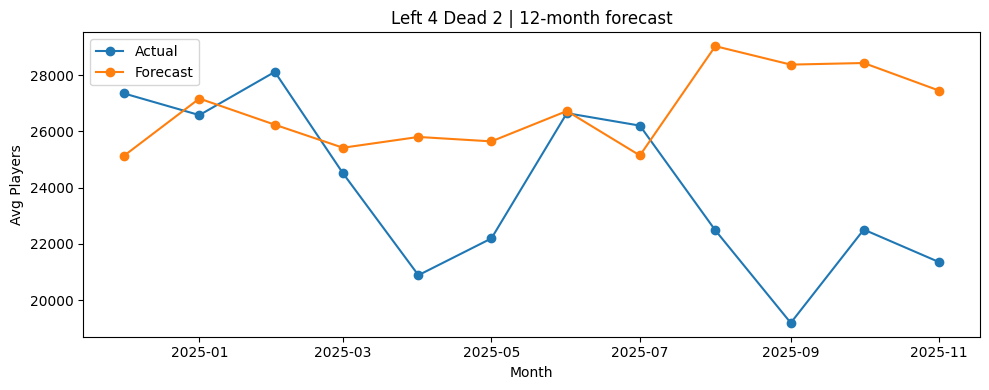

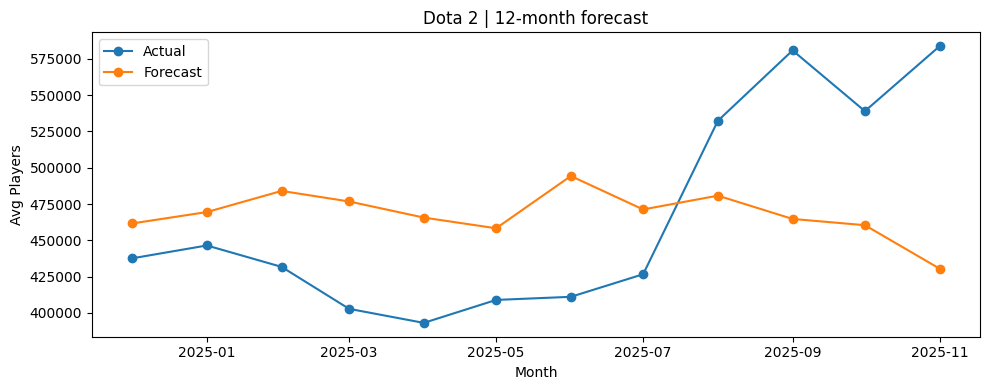

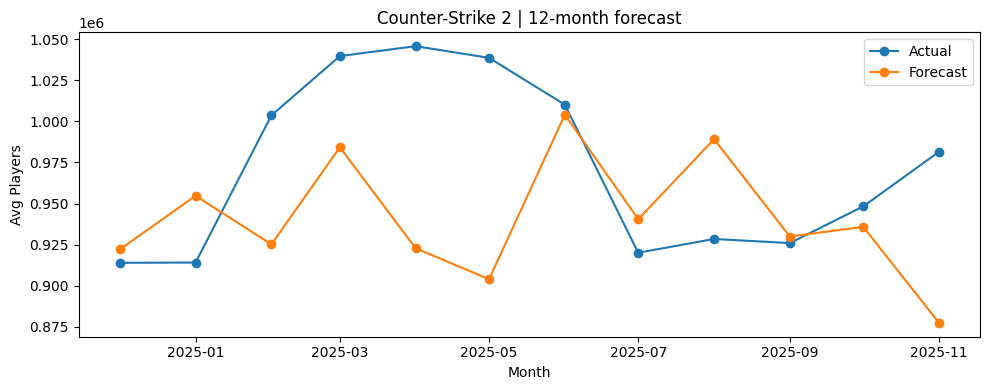

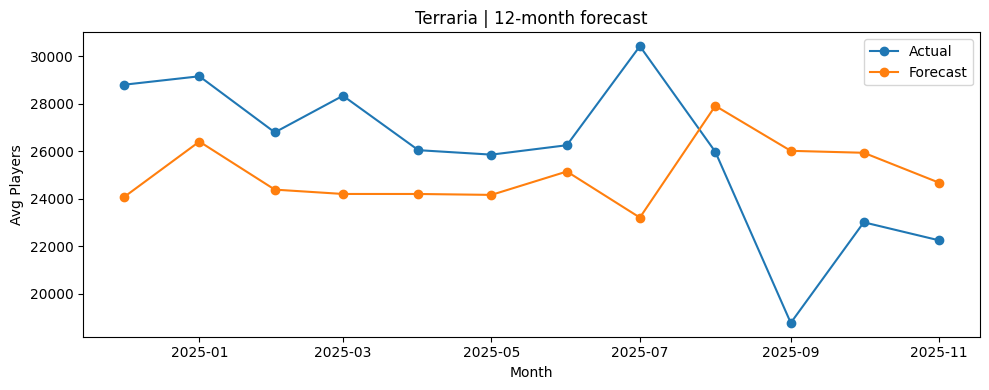

In [116]:
def plot_forecast_only(game_name: str):
    """
    Plot the last available forecast window for one game:
    - Only shows the horizon period: actual vs forecast (no history line).
    """
    g = full_df[full_df["game"] == game_name].sort_values("month").reset_index(drop=True)

    # Need enough months for lookback + horizon
    if len(g) < LOOKBACK + HORIZON:
        print("Not enough history:", game_name)
        return

    cal_cols = [
        "sin_m", "cos_m",
        "ev_winter_holidays",
        "ev_lunar_new_year",
        "ev_valentines",
        "ev_spring_break",
        "ev_summer",
        "ev_back_to_school",
        "ev_halloween",
        "ev_black_friday"
    ]
    exog_now_cols = ["upd_3m", "upd_6m", "tr_3m", "tr_6m"]

    # Target series in log space
    y_series = np.log1p(g["avg_players"].values.astype(float))

    # Last forecast start month that still has HORIZON months of actuals
    t = len(g) - HORIZON

    # Build feature vector exactly as in training
    x_lags = y_series[t - LOOKBACK : t]
    x_exog_now = g.loc[t, exog_now_cols].values.astype(float)
    x_future_cal = g.loc[t : t + HORIZON - 1, cal_cols].values.astype(float).reshape(-1)
    x = np.concatenate([x_lags, x_exog_now, x_future_cal], axis=0)

    # Apply training standardization
    x_z = (x - mu) / sigma
    xt = torch.tensor(x_z, dtype=torch.float32).unsqueeze(0).to(device)

    # Predict standardized y, then unstandardize back to log space
    model.eval()
    with torch.no_grad():
        yz_pred = model(xt).cpu().numpy().reshape(-1)

    y_pred_log = (yz_pred * y_sigma) + y_mu
    y_true_log = y_series[t : t + HORIZON]

    # Convert to original player scale
    pred = np.expm1(y_pred_log)
    true = np.expm1(y_true_log)

    # Corresponding dates
    fut_months = g["month"].iloc[t : t + HORIZON]

    # Plot only forecast vs actual
    plt.figure(figsize=(10, 4))
    plt.plot(fut_months, true, marker="o", label="Actual")
    plt.plot(fut_months, pred, marker="o", label="Forecast")
    plt.title(f"{game_name} | {HORIZON}-month forecast")
    plt.xlabel("Month")
    plt.ylabel("Avg Players")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot a few games to sanity-check forecast behavior visually
for gname in full_df["game"].drop_duplicates().tolist()[:5]:
    plot_forecast_only(gname)

### Save model checkpoint and scalers so results are reproducible from the repo.

In [117]:
from pathlib import Path

# Save artifacts in a dedicated folder
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True)

# Save:
# - model weights
# - X and y normalization stats
# - key hyperparameters used for training/inference
ckpt_path = ARTIFACTS_DIR / "factor_aware_mlp.pt"
torch.save({
    "model_state": model.state_dict(),
    "X_mu": mu,
    "X_sigma": sigma,
    "y_mu": float(y_mu),
    "y_sigma": float(y_sigma),
    "lookback": LOOKBACK,
    "horizon": HORIZON,
}, ckpt_path)

print("Saved model checkpoint:", ckpt_path)

Saved model checkpoint: artifacts/factor_aware_mlp.pt
